# Clustering Evaluation: k=20 vs k=100 Comparison

This notebook evaluates and compares k-medoids clustering results for k=20 and k=100.

**Clustering method**: Directed Weisfeiler-Lehman kernel + k-medoids (CLARA)

- Total graphs: 49,125
- WL iterations: 3
- Includes **Silhouette Score** computation


In [18]:
import json
import pickle
import os
import hashlib
from pathlib import Path
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from typing import List, Dict
from collections import Counter
from scipy import sparse
from sklearn.metrics import silhouette_score, silhouette_samples
from tqdm import tqdm

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10



## 1. Load Clustering Results for Both k Values


In [24]:
# Paths
graphs_dir = '../../graphs/'

# Load k=20 results
with open('../../outputs/selected_graphs_k20.json', 'r') as f:
    results_k20 = json.load(f)

# Load k=100 results
with open('../../outputs/selected_graphs_k100.json', 'r') as f:
    results_k100 = json.load(f)

# Create dictionary for easy access
results = {
    20: results_k20,
    100: results_k100
}

# Display basic info
for k in [20, 100]:
    r = results[k]
    print(f"\n{'='*60}")
    print(f"k = {k}")
    print(f"{'='*60}")
    print(f"Method: {r['method']}")
    print(f"Total graphs: {r['total_graphs']:,}")
    print(f"WL iterations: {r['wl_iterations']}")
    print(f"Inertia: {r['inertia']:.4f}")
    print(f"Selected medoids: {len(r['selected_pickle_files'])}")
    print(f"Cluster sizes: min={min(r['cluster_sizes'])}, max={max(r['cluster_sizes'])}, mean={np.mean(r['cluster_sizes']):.1f}")


k = 20
Method: directed_wl_kernel_kmedoids
Total graphs: 49,125
WL iterations: 3
Inertia: 15677.7067
Selected medoids: 20
Cluster sizes: min=72, max=8370, mean=2456.2

k = 100
Method: directed_wl_kernel_kmedoids
Total graphs: 49,125
WL iterations: 3
Inertia: 14369.5126
Selected medoids: 100
Cluster sizes: min=1, max=3418, mean=491.2


## 2. Compute WL Features for Silhouette Score

We need to recompute the WL features to calculate silhouette scores.


In [25]:


def wl_features_one_graph(G: nx.DiGraph, h: int = 3, hash_dim: int = 2**18) -> Dict[int, float]:
    """Compute WL features for one graph."""

    labels = {}
    for v in G.nodes():
        labels[v] = f"in{G.in_degree(v)}_out{G.out_degree(v)}"
    feat_counts = {}
    
    # Iteration 0
    for v, lab in labels.items():

        s=f"0|{lab}"
        
        mod=hash_dim
        col= int(hashlib.md5(s.encode("utf-8")).hexdigest(), 16) % mod
     
        feat_counts[col] = feat_counts.get(col, 0.0) + 1.0
    
    # WL iterations
    for t in range(1, h + 1):
        new_labels = {}
        for v in G.nodes():
            in_labs = sorted([labels[u] for u in G.predecessors(v)], key=str)
            out_labs = sorted([labels[u] for u in G.successors(v)], key=str)
            sig = f"{labels[v]}|IN:{','.join(in_labs)}|OUT:{','.join(out_labs)}"
            new_lab = hashlib.md5(sig.encode("utf-8")).hexdigest()
            new_labels[v] = new_lab
            s = f"{t}|{new_lab}"
            col = int(hashlib.md5(s.encode("utf-8")).hexdigest(), 16) % hash_dim
            feat_counts[col] = feat_counts.get(col, 0.0) + 1.0
        
        labels = new_labels
    
    return feat_counts

print("WL feature functions defined.")

WL feature functions defined.


In [26]:



graph_files = sorted(glob.glob(os.path.join(graphs_dir, 'graph_*.pickle')))
print(f"Found {len(graph_files)} graph files")

# Compute WL features
print("\nComputing WL features for all graphs...")
hash_dim = 2**18
h = 3

rows = []
cols = []
data = []

for i, fpath in enumerate(tqdm(graph_files, desc="Computing features")):
    with open(fpath, 'rb') as f:
        G = pickle.load(f)
    
    # Handle empty graphs
    if G.number_of_nodes() == 0:
        G.add_node(0)
    
    fd = wl_features_one_graph(G, h=h, hash_dim=hash_dim)
    for c, v in fd.items():
        rows.append(i)
        cols.append(c)
        data.append(v)

X = sparse.csr_matrix((data, (rows, cols)), shape=(len(graph_files), hash_dim), dtype=np.float64)
print(f"\nFeature matrix: {X.shape}, nnz={X.nnz}")

# Normalize features
norms = np.sqrt(X.multiply(X).sum(axis=1)).A1
inv_norms = np.zeros_like(norms)
inv_norms[norms > 0] = 1.0 / norms[norms > 0]
Xn = sparse.diags(inv_norms, format="csr") @ X

print("Feature computation complete!")

Found 49125 graph files

Computing WL features for all graphs...


Computing features: 100%|██████████| 49125/49125 [01:30<00:00, 541.78it/s]



Feature matrix: (49125, 262144), nnz=19817686
Feature computation complete!


## 3. Compute Silhouette Scores

Silhouette score measures how similar an object is to its own cluster compared to other clusters.

- Range: [-1, 1]
- Values near +1: well-clustered
- Values near 0: on cluster boundary
- Values near -1: possibly assigned to wrong cluster


In [27]:
def compute_silhouette_score_sparse(Xn_sparse, labels, sample_size=10000):
    """
    Compute silhouette score using cosine distance on sparse normalized features.
    Uses sampling if dataset is too large.
    """
    n = Xn_sparse.shape[0]
    

    if n > sample_size:
        print(f"Sampling {sample_size} points for silhouette computation...")
        np.random.seed(42)
        sample_idx = np.random.choice(n, sample_size, replace=False)
        Xn_sample = Xn_sparse[sample_idx]
        labels_sample = np.array(labels)[sample_idx]
    else:
        Xn_sample = Xn_sparse
        labels_sample = np.array(labels)
    

    S = (Xn_sample @ Xn_sample.T).toarray()
    S = np.clip(S, -1.0, 1.0)
    

    D = np.sqrt(np.maximum(2.0 - 2.0 * S, 0.0))

    np.fill_diagonal(D, 0.0)
    
    # Compute silhouette score
    print("Computing silhouette score...")
    score = silhouette_score(D, labels_sample, metric='precomputed')
    

    sample_scores = silhouette_samples(D, labels_sample, metric='precomputed')
    
    return score, sample_scores, labels_sample

# Compute for both k values
silhouette_results = {}

for k in [20, 100]:
    print(f"\n{'='*60}")
    print(f"Computing Silhouette Score for k={k}")
    print(f"{'='*60}")
    
    labels = np.array(results[k]['cluster_labels'])
    score, sample_scores, sample_labels = compute_silhouette_score_sparse(Xn, labels, sample_size=10000)
    
    silhouette_results[k] = {
        'score': score,
        'sample_scores': sample_scores,
        'sample_labels': sample_labels
    }
    
    print(f"\nSilhouette Score (k={k}): {score:.4f}")
    print(f"  Mean per-cluster:")
    for cluster_id in range(k):
        cluster_mask = sample_labels == cluster_id
        if cluster_mask.sum() > 0:
            cluster_sil = sample_scores[cluster_mask].mean()
            print(f"    Cluster {cluster_id:3d}: {cluster_sil:7.4f} (n={cluster_mask.sum()})")


Computing Silhouette Score for k=20
Sampling 10000 points for silhouette computation...
Computing silhouette score...

Silhouette Score (k=20): 0.0025
  Mean per-cluster:
    Cluster   0:  0.0560 (n=1213)
    Cluster   1:  0.0429 (n=337)
    Cluster   2: -0.1334 (n=526)
    Cluster   3:  0.7734 (n=23)
    Cluster   4:  0.2588 (n=15)
    Cluster   5: -0.0157 (n=105)
    Cluster   6: -0.0184 (n=1329)
    Cluster   7:  0.1993 (n=17)
    Cluster   8:  0.3727 (n=46)
    Cluster   9:  0.3829 (n=14)
    Cluster  10:  0.0379 (n=1289)
    Cluster  11:  0.1587 (n=14)
    Cluster  12: -0.1246 (n=1516)
    Cluster  13: -0.0314 (n=1788)
    Cluster  14:  1.0000 (n=91)
    Cluster  15: -0.1025 (n=262)
    Cluster  16:  0.0095 (n=853)
    Cluster  17:  0.0528 (n=367)
    Cluster  18:  0.1378 (n=117)
    Cluster  19:  1.0000 (n=78)

Computing Silhouette Score for k=100
Sampling 10000 points for silhouette computation...
Computing silhouette score...

Silhouette Score (k=100): 0.0217
  Mean per-cluste

## 4. Comparison Summary


In [28]:
# Create comparison table
comparison_data = []
for k in [20, 100]:
    r = results[k]
    sizes = r['cluster_sizes']
    weights = r['cluster_weights']
    
    # Coefficient of variation
    cv = np.std(sizes) / np.mean(sizes)
    
    # Effective number of clusters (entropy)
    entropy = -np.sum([w * np.log(w) if w > 0 else 0 for w in weights])
    effective_k = np.exp(entropy)
    
    comparison_data.append({
        'k': k,
        'Inertia': r['inertia'],
        'Silhouette': silhouette_results[k]['score'],
        'Min Size': min(sizes),
        'Max Size': max(sizes),
        'Mean Size': np.mean(sizes),
        'Std Size': np.std(sizes),
        'CV': cv,
        'Effective k': effective_k,
        'Efficiency (%)': effective_k / k * 100
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("CLUSTERING QUALITY COMPARISON: k=20 vs k=100")
print("="*80)
print(comparison_df.to_string(index=False))




CLUSTERING QUALITY COMPARISON: k=20 vs k=100
  k      Inertia  Silhouette  Min Size  Max Size  Mean Size    Std Size       CV  Effective k  Efficiency (%)
 20 15677.706675    0.002534        72      8370    2456.25 2829.901569 1.152123    10.447207       52.236035
100 14369.512559    0.021733         1      3418     491.25  748.042571 1.522733    42.976361       42.976361


## 5. Visualization: k=20 Detailed Analysis


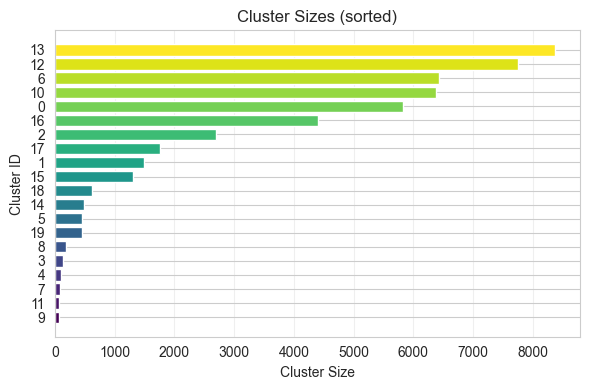

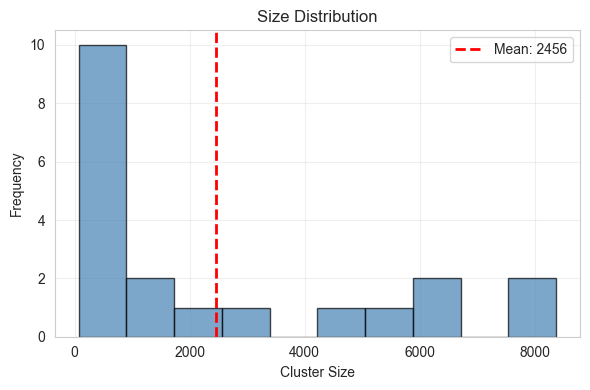

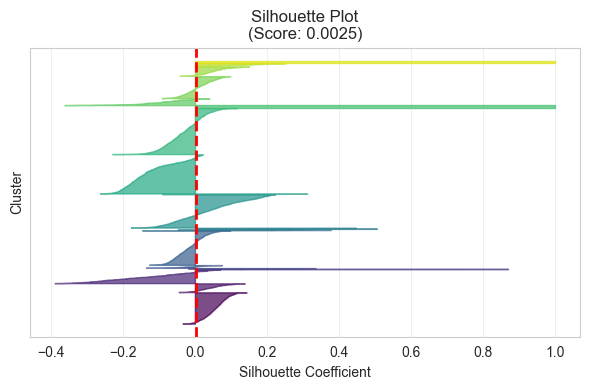

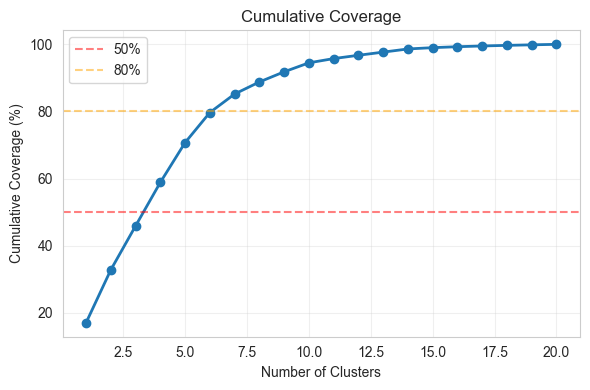

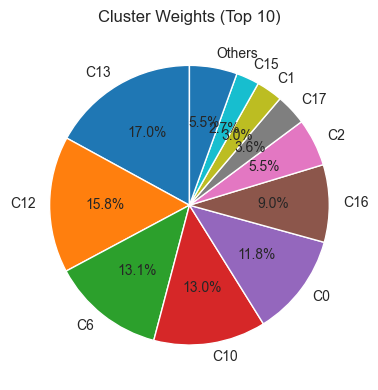

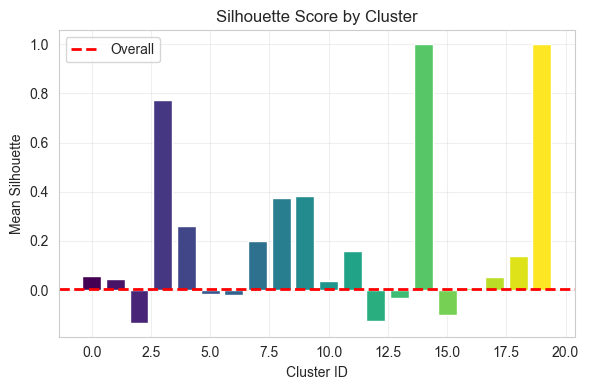

In [29]:
k = 20
r = results[k]

# Shared data
colors = plt.cm.viridis(np.linspace(0, 1, k))
sample_scores = silhouette_results[k]['sample_scores']
sample_labels = silhouette_results[k]['sample_labels']

# 5.1 Cluster sizes
plt.figure(figsize=(6, 4))
ax = plt.gca()
cluster_df = pd.DataFrame({
    'Cluster': range(k),
    'Size': r['cluster_sizes']
}).sort_values('Size', ascending=True)
ax.barh(range(k), cluster_df['Size'], color=colors)
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Cluster ID')
ax.set_title('Cluster Sizes (sorted)')
ax.set_yticks(range(k))
ax.set_yticklabels(cluster_df['Cluster'])
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# 5.2 Size distribution
plt.figure(figsize=(6, 4))
ax = plt.gca()
ax.hist(r['cluster_sizes'], bins=10, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(np.mean(r['cluster_sizes']), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {np.mean(r["cluster_sizes"]):.0f}')
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Frequency')
ax.set_title('Size Distribution')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5.3 Silhouette plot
plt.figure(figsize=(6, 4))
ax = plt.gca()
y_lower = 10
for i in range(k):
    cluster_scores = sample_scores[sample_labels == i]
    cluster_scores = np.sort(cluster_scores)

    size_cluster_i = cluster_scores.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.viridis(float(i) / k)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_scores,
                     facecolor=color, edgecolor=color, alpha=0.7)

    y_lower = y_upper + 10

ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')
ax.set_title(f'Silhouette Plot\n(Score: {silhouette_results[k]["score"]:.4f})')
ax.axvline(x=silhouette_results[k]['score'], color="red", linestyle="--", linewidth=2)
ax.set_yticks([])
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5.4 Cumulative coverage
plt.figure(figsize=(6, 4))
ax = plt.gca()
sorted_weights = np.sort(r['cluster_weights'])[::-1]
cumulative = np.cumsum(sorted_weights)
ax.plot(range(1, k+1), cumulative * 100, marker='o', linewidth=2, markersize=6)
ax.axhline(50, color='red', linestyle='--', alpha=0.5, label='50%')
ax.axhline(80, color='orange', linestyle='--', alpha=0.5, label='80%')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Cumulative Coverage (%)')
ax.set_title('Cumulative Coverage')
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# 5.5 Cluster weights pie
plt.figure(figsize=(6, 4))
ax = plt.gca()
top_n = 10
sorted_w = sorted(enumerate(r['cluster_weights']), key=lambda x: x[1], reverse=True)
top_clusters = sorted_w[:top_n]
other_weight = sum(w for _, w in sorted_w[top_n:])

labels = [f"C{i}" for i, w in top_clusters]
sizes = [w for _, w in top_clusters]
if other_weight > 0:
    labels.append("Others")
    sizes.append(other_weight)

ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.set_title(f'Cluster Weights (Top {top_n})')
plt.tight_layout()
plt.show()

# 5.6 Silhouette by cluster
plt.figure(figsize=(6, 4))
ax = plt.gca()
cluster_sil_means = []
for i in range(k):
    mask = sample_labels == i
    if mask.sum() > 0:
        cluster_sil_means.append(sample_scores[mask].mean())
    else:
        cluster_sil_means.append(0)

ax.bar(range(k), cluster_sil_means, color=colors)
ax.axhline(silhouette_results[k]['score'], color='red', linestyle='--', linewidth=2, label='Overall')
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Mean Silhouette')
ax.set_title('Silhouette Score by Cluster')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Visualization: k=100 Detailed Analysis


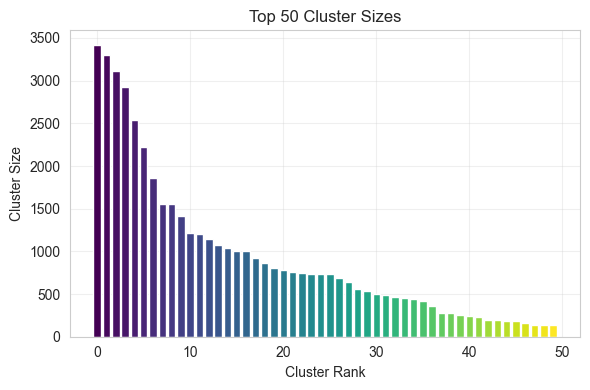

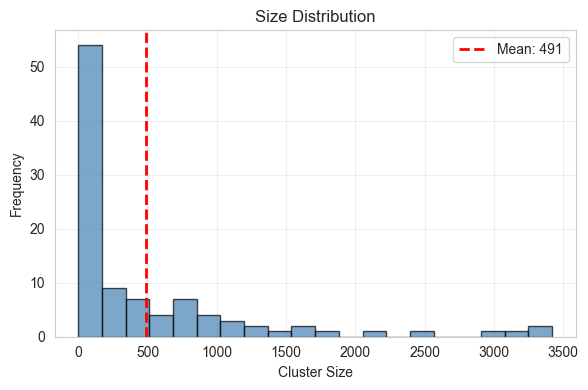

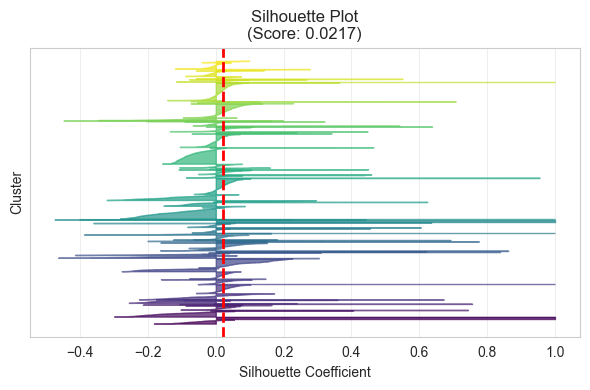

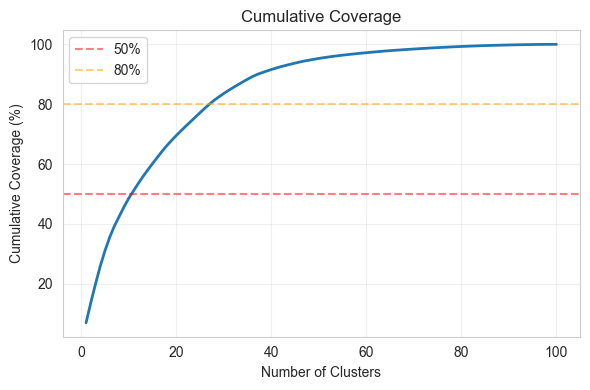

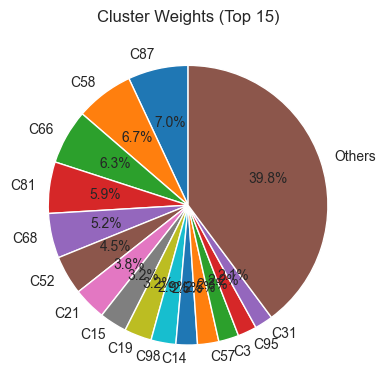

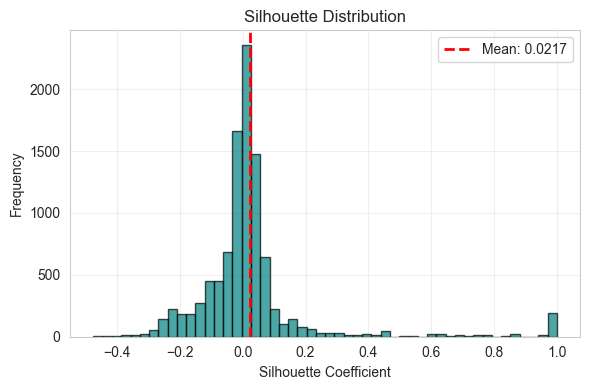

In [30]:
k = 100
r = results[k]

# Shared data
sample_scores = silhouette_results[k]['sample_scores']
sample_labels = silhouette_results[k]['sample_labels']

# 6.1 Cluster sizes (top 50)
plt.figure(figsize=(6, 4))
ax = plt.gca()
cluster_df = pd.DataFrame({
    'Cluster': range(k),
    'Size': r['cluster_sizes']
}).sort_values('Size', ascending=False).head(50)
colors_top50 = plt.cm.viridis(np.linspace(0, 1, 50))
ax.bar(range(50), cluster_df['Size'], color=colors_top50)
ax.set_xlabel('Cluster Rank')
ax.set_ylabel('Cluster Size')
ax.set_title('Top 50 Cluster Sizes')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'../../outputs/clustering_analysis_k{k}_top50_sizes.png', dpi=300, bbox_inches='tight')
plt.show()

# 6.2 Size distribution
plt.figure(figsize=(6, 4))
ax = plt.gca()
ax.hist(r['cluster_sizes'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(np.mean(r['cluster_sizes']), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {np.mean(r["cluster_sizes"]):.0f}')
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Frequency')
ax.set_title('Size Distribution')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'../../outputs/clustering_analysis_k{k}_size_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 6.3 Silhouette plot (sample)
plt.figure(figsize=(6, 4))
ax = plt.gca()
y_lower = 10
for i in range(k):
    cluster_scores = sample_scores[sample_labels == i]
    cluster_scores = np.sort(cluster_scores)

    size_cluster_i = cluster_scores.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.viridis(float(i) / k)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_scores,
                     facecolor=color, edgecolor=color, alpha=0.7)

    y_lower = y_upper + 10

ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')
ax.set_title(f'Silhouette Plot\n(Score: {silhouette_results[k]["score"]:.4f})')
ax.axvline(x=silhouette_results[k]['score'], color="red", linestyle="--", linewidth=2)
ax.set_yticks([])
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'../../outputs/clustering_analysis_k{k}_silhouette_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# 6.4 Cumulative coverage
plt.figure(figsize=(6, 4))
ax = plt.gca()
sorted_weights = np.sort(r['cluster_weights'])[::-1]
cumulative = np.cumsum(sorted_weights)
ax.plot(range(1, k+1), cumulative * 100, linewidth=2)
ax.axhline(50, color='red', linestyle='--', alpha=0.5, label='50%')
ax.axhline(80, color='orange', linestyle='--', alpha=0.5, label='80%')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Cumulative Coverage (%)')
ax.set_title('Cumulative Coverage')
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.savefig(f'../../outputs/clustering_analysis_k{k}_cumulative_coverage.png', dpi=300, bbox_inches='tight')
plt.show()

# 6.5 Cluster weights pie (top 15)
plt.figure(figsize=(6, 4))
ax = plt.gca()
top_n = 15
sorted_w = sorted(enumerate(r['cluster_weights']), key=lambda x: x[1], reverse=True)
top_clusters = sorted_w[:top_n]
other_weight = sum(w for _, w in sorted_w[top_n:])

labels = [f"C{i}" for i, w in top_clusters]
sizes = [w for _, w in top_clusters]
if other_weight > 0:
    labels.append("Others")
    sizes.append(other_weight)

ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.set_title(f'Cluster Weights (Top {top_n})')
plt.tight_layout()
plt.savefig(f'../../outputs/clustering_analysis_k{k}_weights_pie.png', dpi=300, bbox_inches='tight')
plt.show()

# 6.6 Silhouette distribution
plt.figure(figsize=(6, 4))
ax = plt.gca()
ax.hist(sample_scores, bins=50, color='teal', edgecolor='black', alpha=0.7)
ax.axvline(silhouette_results[k]['score'], color='red', linestyle='--', linewidth=2,
           label=f'Mean: {silhouette_results[k]["score"]:.4f}')
ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Frequency')
ax.set_title('Silhouette Distribution')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
# plt.savefig(f'../../outputs/clustering_analysis_k{k}_silhouette_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


## 7. Side-by-Side Comparison Plots


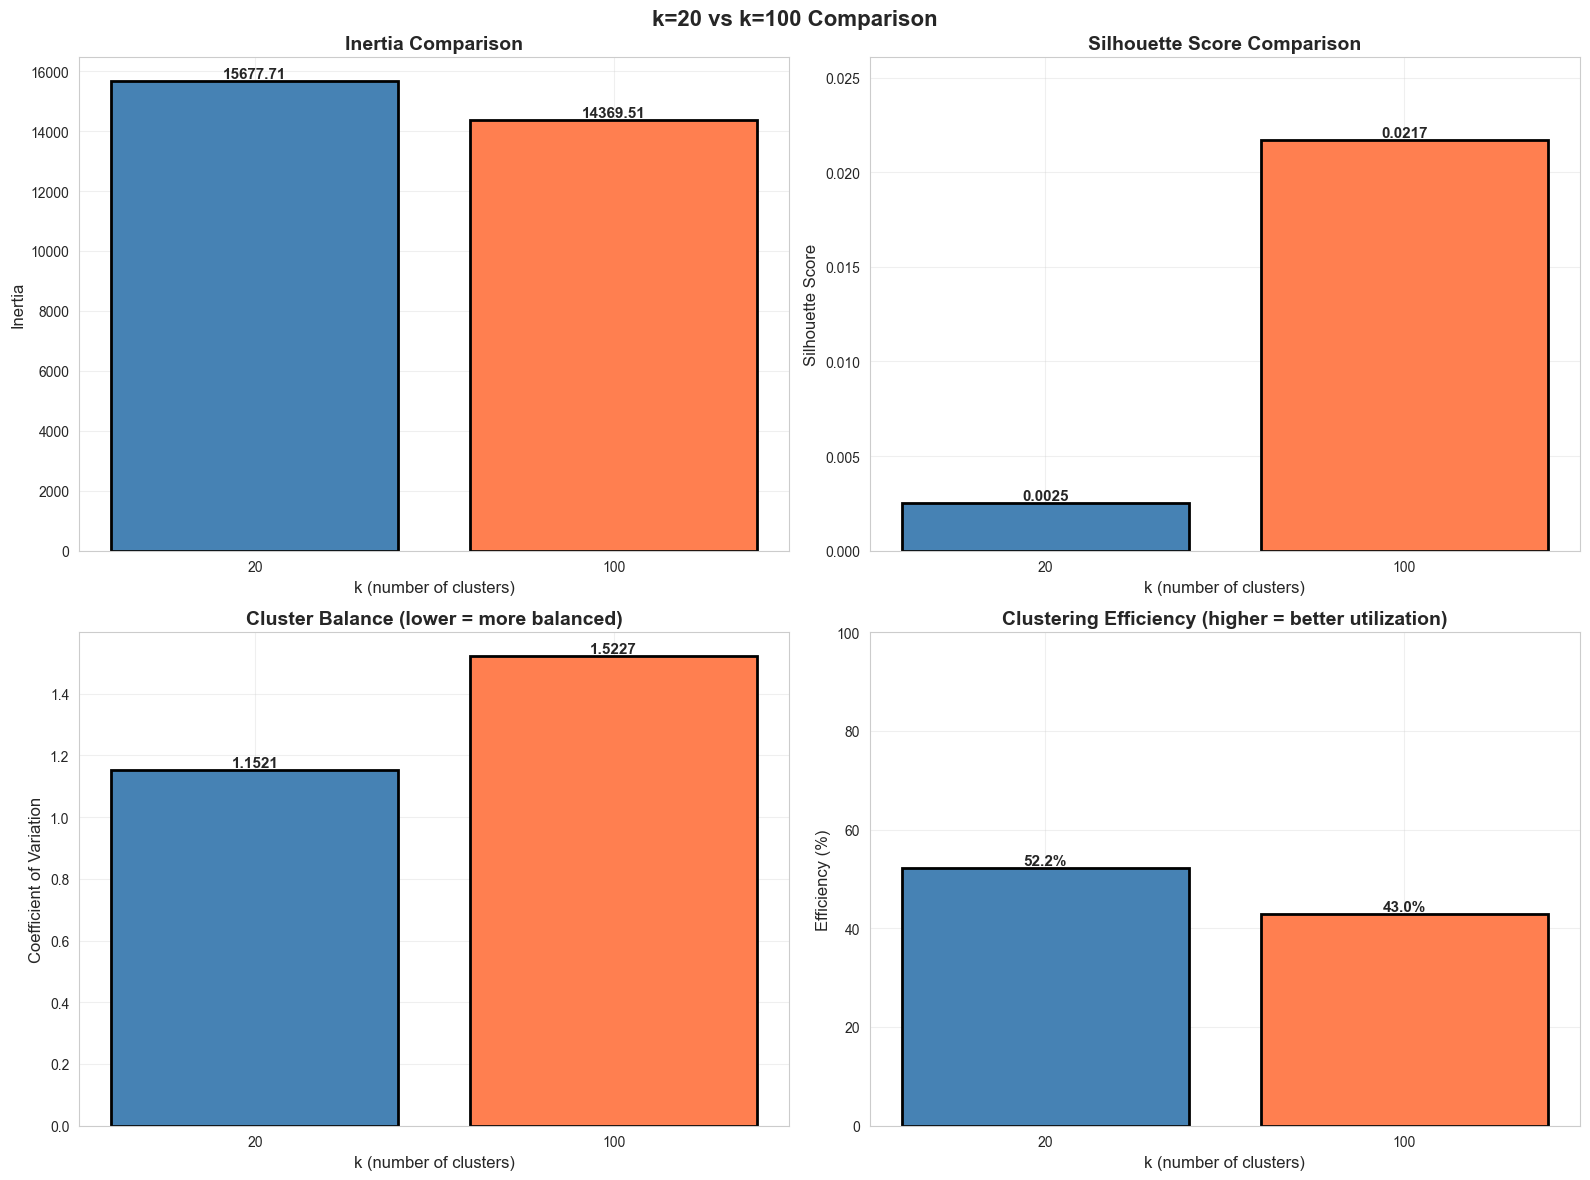

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('k=20 vs k=100 Comparison', fontsize=16, fontweight='bold')

# 7.1 Inertia comparison
ax = axes[0, 0]
k_values = [20, 100]
inertias = [results[k]['inertia'] for k in k_values]
colors_bars = ['steelblue', 'coral']
bars = ax.bar([str(k) for k in k_values], inertias, color=colors_bars, edgecolor='black', linewidth=2)
ax.set_xlabel('k (number of clusters)', fontsize=12)
ax.set_ylabel('Inertia', fontsize=12)
ax.set_title('Inertia Comparison', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
for bar, val in zip(bars, inertias):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 7.2 Silhouette comparison
ax = axes[0, 1]
silhouettes = [silhouette_results[k]['score'] for k in k_values]
bars = ax.bar([str(k) for k in k_values], silhouettes, color=colors_bars, edgecolor='black', linewidth=2)
ax.set_xlabel('k (number of clusters)', fontsize=12)
ax.set_ylabel('Silhouette Score', fontsize=12)
ax.set_title('Silhouette Score Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0, max(silhouettes) * 1.2])
ax.grid(alpha=0.3)
for bar, val in zip(bars, silhouettes):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 7.3 Cluster balance (CV)
ax = axes[1, 0]
cvs = [np.std(results[k]['cluster_sizes']) / np.mean(results[k]['cluster_sizes']) for k in k_values]
bars = ax.bar([str(k) for k in k_values], cvs, color=colors_bars, edgecolor='black', linewidth=2)
ax.set_xlabel('k (number of clusters)', fontsize=12)
ax.set_ylabel('Coefficient of Variation', fontsize=12)
ax.set_title('Cluster Balance (lower = more balanced)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
for bar, val in zip(bars, cvs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 7.4 Efficiency
ax = axes[1, 1]
efficiencies = []
for k in k_values:
    weights = results[k]['cluster_weights']
    entropy = -np.sum([w * np.log(w) if w > 0 else 0 for w in weights])
    effective_k = np.exp(entropy)
    efficiencies.append(effective_k / k * 100)

bars = ax.bar([str(k) for k in k_values], efficiencies, color=colors_bars, edgecolor='black', linewidth=2)
ax.set_xlabel('k (number of clusters)', fontsize=12)
ax.set_ylabel('Efficiency (%)', fontsize=12)
ax.set_title('Clustering Efficiency (higher = better utilization)', fontsize=14, fontweight='bold')
ax.set_ylim([0, 100])
ax.grid(alpha=0.3)
for bar, val in zip(bars, efficiencies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../../outputs/comparison_k20_vs_k100.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Save Comprehensive Report


In [32]:
# Create comprehensive report
report = {
    'comparison_summary': comparison_df.to_dict('records'),
    'silhouette_scores': {
        'k20': float(silhouette_results[20]['score']),
        'k100': float(silhouette_results[100]['score'])
    },
    'k20': {
        'selected_files': results[20]['selected_pickle_files'],
        'cluster_sizes': results[20]['cluster_sizes'],
        'cluster_weights': results[20]['cluster_weights'],
        'inertia': results[20]['inertia'],
        'silhouette': float(silhouette_results[20]['score'])
    },
    'k100': {
        'selected_files': results[100]['selected_pickle_files'],
        'cluster_sizes': results[100]['cluster_sizes'],
        'cluster_weights': results[100]['cluster_weights'],
        'inertia': results[100]['inertia'],
        'silhouette': float(silhouette_results[100]['score'])
    },
    'recommendation': ''
}


print(f"\nk=20 Silhouette Score: {silhouette_results[20]['score']:.4f}")
print(f"k=100 Silhouette Score: {silhouette_results[100]['score']:.4f}")




k=20 Silhouette Score: 0.0025
k=100 Silhouette Score: 0.0217


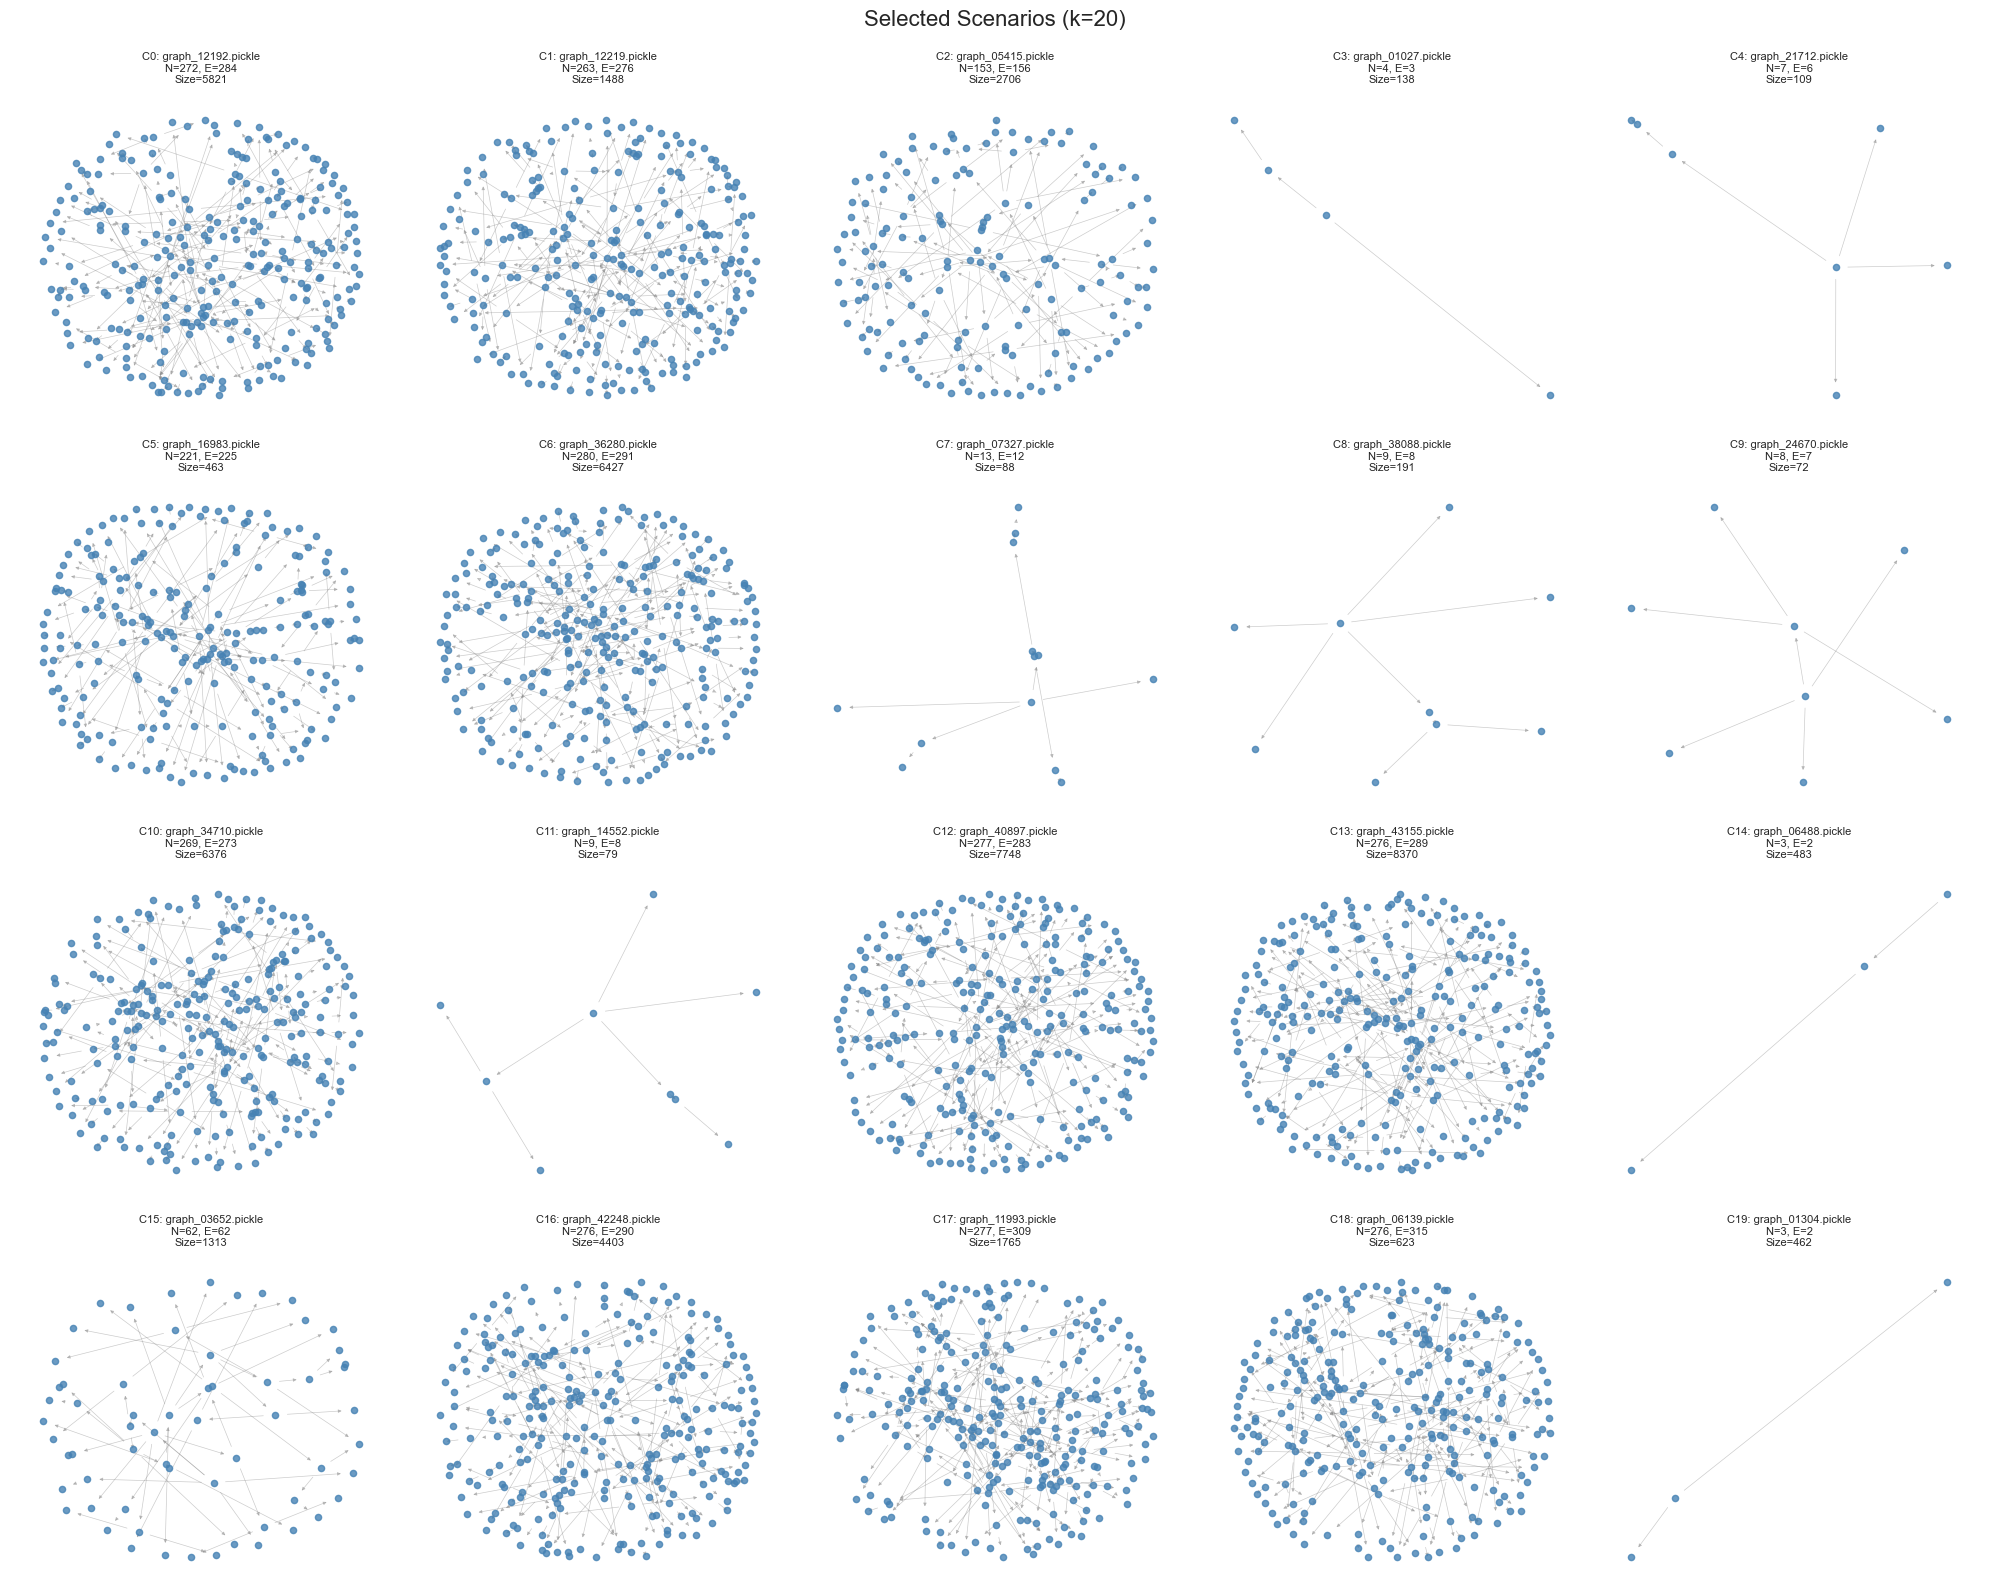

In [34]:
# Plot selected graphs in a grid
import select
k=20

n_cols = 5
n_rows = int(np.ceil(k / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))
axes = axes.flatten()
selected_files = results[k]['selected_pickle_files']
selected_graphs = []
cluster_sizes = results[k]['cluster_sizes']
for fpath in selected_files:
    with open(os.path.join(graphs_dir, fpath), 'rb') as f:
        G = pickle.load(f)
    selected_graphs.append(G)

for i, (G, filename) in enumerate(zip(selected_graphs, selected_files)):
    ax = axes[i]
    
    # Use spring layout for visualization
    if G.number_of_nodes() > 0:
        pos = nx.spring_layout(G, seed=42, k=0.5, iterations=50)
        
        # Draw graph
        nx.draw_networkx_nodes(G, pos, node_size=20, node_color='steelblue', alpha=0.8, ax=ax)
        nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.4, arrows=True, 
                              arrowsize=5, width=0.5, ax=ax)
    
    ax.set_title(f"C{i}: {filename}\nN={G.number_of_nodes()}, E={G.number_of_edges()}\nSize={cluster_sizes[i]}",
                fontsize=8)
    ax.axis('off')

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.suptitle(f'Selected Scenarios (k={k})', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

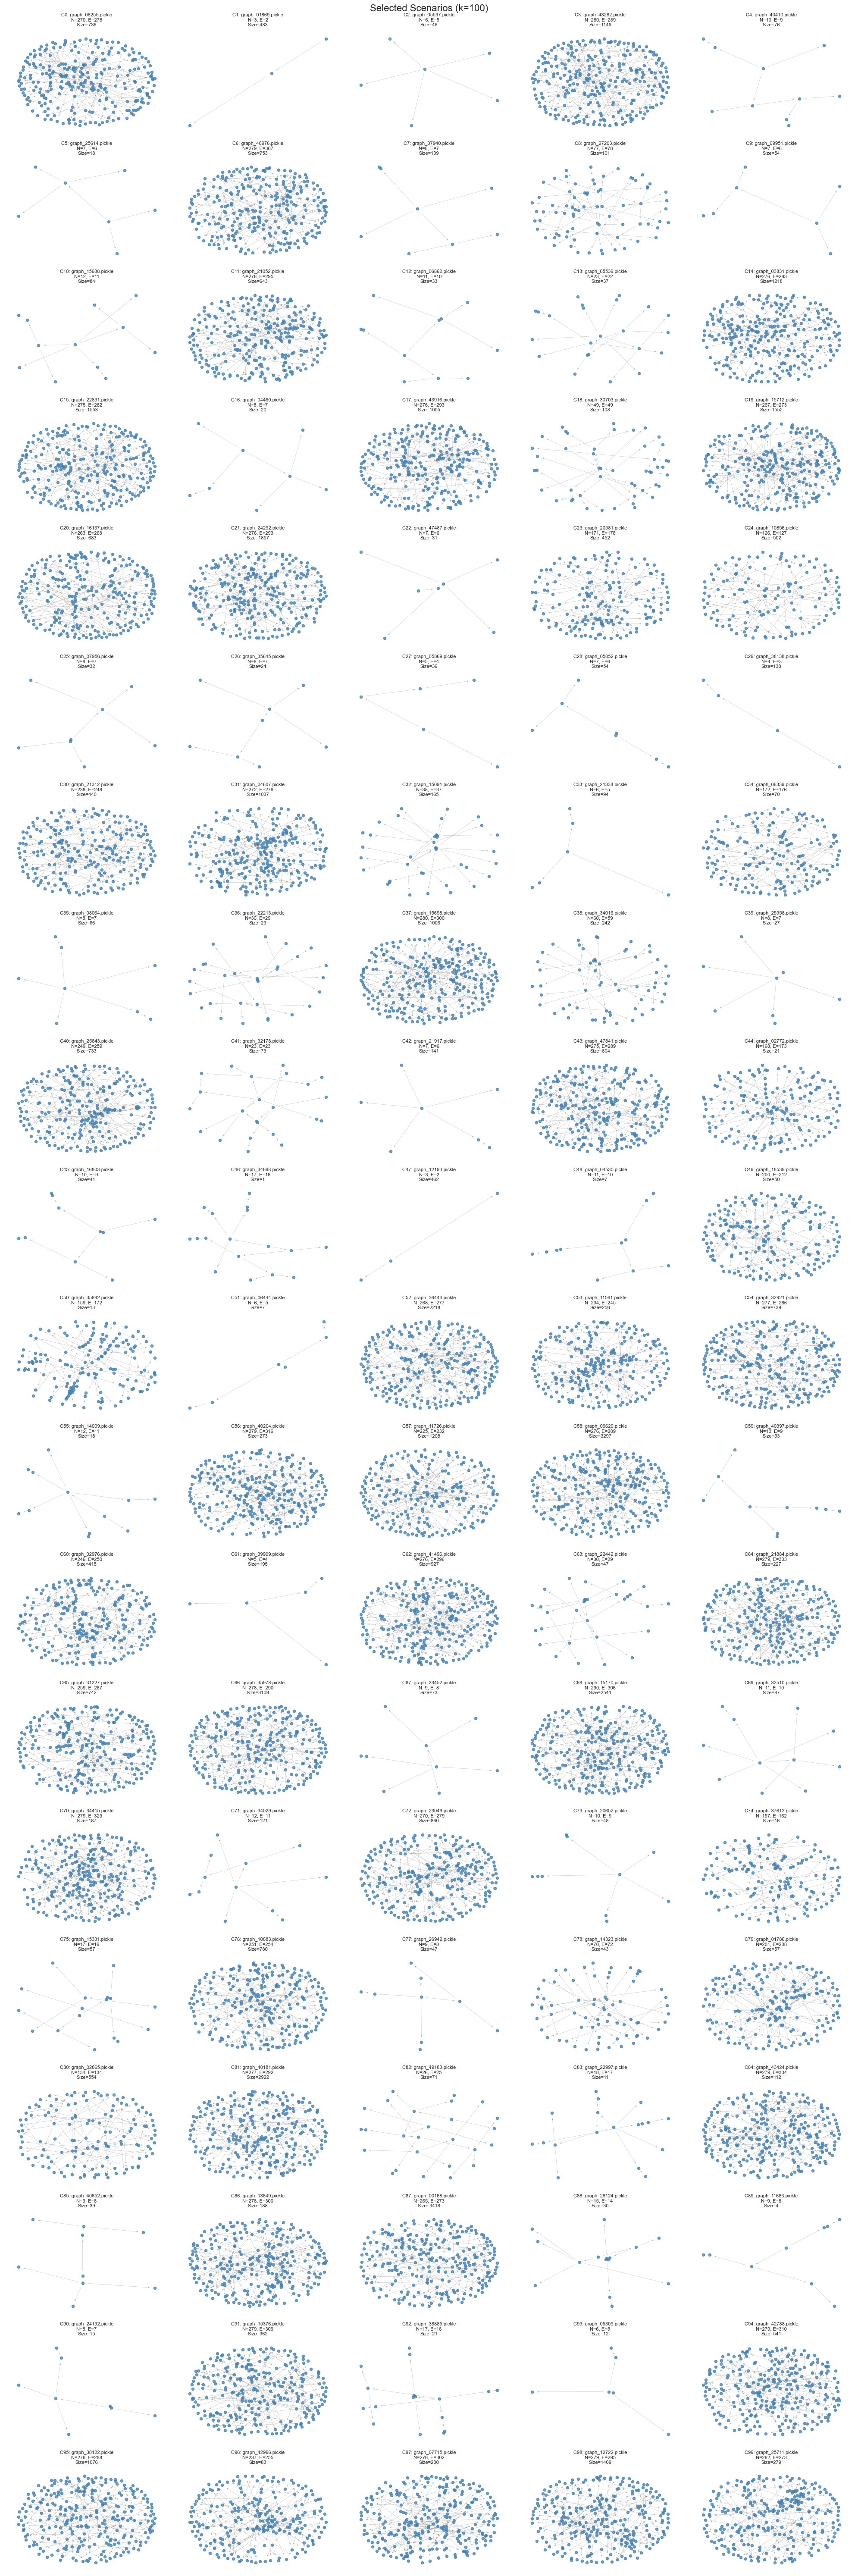

In [ ]:
k=100

n_cols = 5
n_rows = int(np.ceil(k / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 60))
axes = axes.flatten()
selected_files = results[k]['selected_pickle_files']
selected_graphs = []
cluster_sizes = results[k]['cluster_sizes']
for fpath in selected_files:
    with open(os.path.join(graphs_dir, fpath), 'rb') as f:
        G = pickle.load(f)
    selected_graphs.append(G)

for i, (G, filename) in enumerate(zip(selected_graphs, selected_files)):
    ax = axes[i]

    if G.number_of_nodes() > 0:
        pos = nx.spring_layout(G, seed=42, k=0.5, iterations=50)
        
        # Draw graph
        nx.draw_networkx_nodes(G, pos, node_size=20, node_color='steelblue', alpha=0.8, ax=ax)
        nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.4, arrows=True, 
                              arrowsize=5, width=0.5, ax=ax)
    
    ax.set_title(f"C{i}: {filename}\nN={G.number_of_nodes()}, E={G.number_of_edges()}\nSize={cluster_sizes[i]}",
                fontsize=8)
    ax.axis('off')


for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.suptitle(f'Selected Scenarios (k={k})', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()